**Predict 'next-day' price utilizing tensorflow / keras neural network model.**

In [ ]:
# Import Libraries

import numpy as np
import pandas as pd
import pandas_datareader as web
import datetime as dt
import matplotlib.pyplot as plt
plt.style.use('seaborn')

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

In [ ]:
# Rename the ticker symbol for easier use later

company = 'BTC-USD'

# Import BitCoin-USD data from yahoo

data = web.DataReader(company, data_source='yahoo', start='2016-01-01', end='2020-12-30')

In [ ]:
data.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2016-01-01,436.246002,427.515015,430.721008,434.334015,36278900.0,434.334015
2016-01-02,436.062012,431.869995,434.622009,433.437988,30096600.0,433.437988
2016-01-03,433.743011,424.705994,433.578003,430.010986,39633800.0,430.010986
2016-01-04,434.516998,429.084015,430.061005,433.091003,38477500.0,433.091003
2016-01-05,434.182007,429.675995,433.069000,431.959991,34522600.0,431.959991


In [ ]:
data.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-12-27,28288.839844,25922.769531,26439.373047,26272.294922,6.647990e+10,26272.294922
2020-12-28,27389.111328,26207.640625,26280.822266,27084.808594,4.905674e+10,27084.808594
2020-12-29,27370.720703,25987.298828,27081.810547,27362.437500,4.526595e+10,27362.437500
2020-12-30,28937.740234,27360.089844,27360.089844,28840.953125,5.128744e+10,28840.953125
2020-12-31,29244.876953,28201.992188,28841.574219,29001.720703,4.675496e+10,29001.720703


In [ ]:
# Review the size of the dataset
data.shape

(1823, 6)

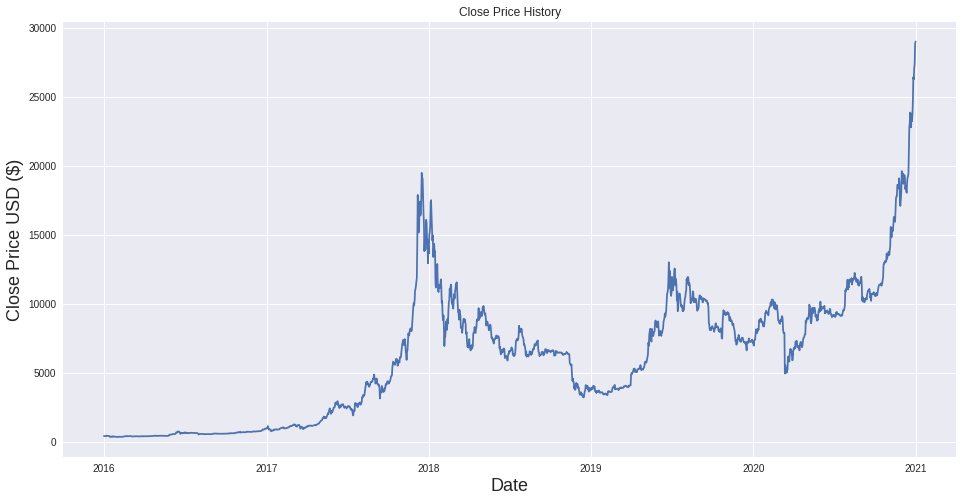

In [ ]:
# Vizualise the closing price history
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(data['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [ ]:
# Scale the data

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))


In [ ]:
# Define the training data 

prediction_days = 60

x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):
  x_train.append(scaled_data[x-prediction_days:x, 0])
  y_train.append(scaled_data[x, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [ ]:
# Build and train the Model - 25 Epochs

model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1)) # Prediction of the next closing price

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=25, batch_size=32)



Epoch 1/25
56/56 [==============================] - 10s 81ms/step - loss: 0.0074
Epoch 2/25
56/56 [==============================] - 5s 88ms/step - loss: 0.0019
Epoch 3/25
56/56 [==============================] - 5s 87ms/step - loss: 0.0019
Epoch 4/25
56/56 [==============================] - 5s 86ms/step - loss: 0.0017
Epoch 5/25
56/56 [==============================] - 5s 86ms/step - loss: 0.0022
Epoch 6/25
56/56 [==============================] - 5s 87ms/step - loss: 0.0016
Epoch 7/25
56/56 [==============================] - 5s 87ms/step - loss: 0.0012
Epoch 8/25
56/56 [==============================] - 5s 88ms/step - loss: 0.0012
Epoch 9/25
56/56 [==============================] - 5s 87ms/step - loss: 0.0012
Epoch 10/25
56/56 [==============================] - 5s 87ms/step - loss: 0.0012
Epoch 11/25
56/56 [==============================] - 5s 88ms/step - loss: 0.0015
Epoch 12/25
56/56 [==============================] - 5s 88ms/step - loss: 0.0012
Epoch 13/25
56/56 [=================

Test the Model Accuracy on Existing Data

In [ ]:
# Load test data

test_start = dt.datetime(2021,1,1)
test_end = dt.datetime.now()

test_data = web.DataReader(company, 'yahoo', test_start, test_end)
actual_prices = test_data['Close'].values

total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)

model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.transform(model_inputs)

In [ ]:
# Make predictions on test data

x_test = []

for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

**Remember that the prices predicted have been scaled from 0 - 1. We need to reverse scale them so they are interpretable.**

In [ ]:
predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

<function matplotlib.pyplot.show>

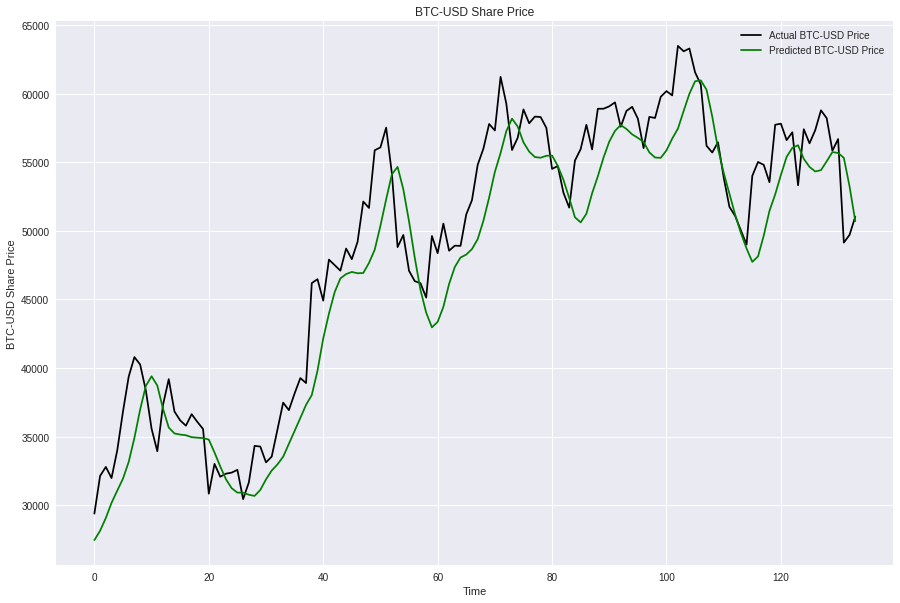

In [ ]:
# Now lets view the test predictions

plt.figure(figsize=(15, 10))
plt.plot(actual_prices, color="black", label=f"Actual {company} Price",)
plt.plot(predicted_prices, color="green", label=f"Predicted {company} Price")
plt.title(f"{company} Share Price")
plt.xlabel('Time')
plt.ylabel(f'{company} Share Price')
plt.legend()
plt.show

In [ ]:
# Now to predict the next day

real_data = [model_inputs[len(model_inputs) + 1 - prediction_days:len(model_inputs+1), 0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1],1))

prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print(f"Prediction: {prediction}")

Prediction: [[48842.258]]
